Compiling and post-processing water track data

In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from pathlib import Path
import pandas as pd
import numpy as np
import glob

import matplotlib
matplotlib.rcParams.update({"pdf.fonttype":42})

# Import and organize field data

In [2]:
wt_field_data = {}

## Upper Kuparuk (Toolik)

In [3]:
uk_data = {}
# Compile all the data and melt it

p = Path(f'./upper_kuparuk_data/')

wt_list = [f.stem for f in Path.glob(p, 'wt*.csv')]

for i, wt in enumerate(wt_list):
    df = pd.read_csv(f'./upper_kuparuk_data/{wt}.csv')

    df['time'] = pd.to_datetime(df['TIMESTAMP'])
    df.index = df['time']
    
    # https://pandas.pydata.org/docs/reference/api/pandas.melt.html
    df_melt = pd.melt(df.drop('TIMESTAMP', axis=1), id_vars=['time'])

    df_melt['wt'] = wt

    # https://stackoverflow.com/questions/14745022/how-to-split-a-dataframe-string-column-into-two-columns

    df_melt[['loc', 'depth']] = df_melt['variable'].str.split('_', n=1, expand=True)

    df_melt['depth'] = df_melt['depth'].astype('float')

    # df_melt = df_melt.sort_values(by='time')

    

    if i == 0:
        df_save = df_melt
    try:
        # df_save = pd.merge(df_save, df_melt, on='time', how='outer')
        # issue with inconsistent timestamps??
        df_save = pd.concat([df_save, df_melt]).reset_index().drop(columns='level_0')
    except KeyError:
        df_save = pd.concat([df_save, df_melt]).reset_index()

uk_data['time_series'] = df_save.reset_index().drop(columns='level_0')

C:\Users\jdelvecchio01\AppData\Local\Temp\ipykernel_33484\2587937868.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['TIMESTAMP'])
C:\Users\jdelvecchio01\AppData\Local\Temp\ipykernel_33484\2587937868.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['TIMESTAMP'])
C:\Users\jdelvecchio01\AppData\Local\Temp\ipykernel_33484\2587937868.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['TIMESTAMP'])
C:\Users\jdelvecchio01\AppData\Local\Temp\ipykernel_33484\2587937868.py:11: Use

In [62]:
# Generate site-specific list of depths
uk_data['depth_list'] = list(df_save['depth'].unique())
uk_data['depth_list']

[2.0, 4.0, 6.0, 8.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0]

### 1D resampling and plot: Get data for WT6 for year 2013

In [5]:
def resample_and_plot_1D(wt_number, resample, year=None, plot=True):
    wt = uk_data['time_series'][uk_data['time_series']['wt']==wt_number]

    wt_in = wt[wt['loc']=='in']
    wt_out = wt[wt['loc']=='out']

    if year is not None:

        if wt_in.query(f'{year}0101 < time < {year}1231').empty:
            print('No data for that time')
            return None, None
        else:
            resampled_in = wt_in.query(f'{year}0101 < time < {year}1231').drop(['variable','wt','loc'], axis=1).groupby('depth').resample(resample, on='time').mean().droplevel(level=0).reset_index()
            resampled_out = wt_out.query(f'{year}0101 < time < {year}1231').drop(['variable','wt','loc'], axis=1).groupby('depth').resample(resample, on='time').mean().droplevel(level=0).reset_index()


    else: 
        resampled_in = wt_in.drop(['variable','wt','loc'], axis=1).groupby('depth').resample(resample, on='time').mean().droplevel(level=0).reset_index()
        resampled_out = wt_out.drop(['variable','wt','loc'], axis=1).groupby('depth').resample(resample, on='time').mean().droplevel(level=0).reset_index()

    if plot==True:
        cmap = plt.get_cmap('gist_rainbow')
        cmap_list = cmap(np.linspace(0.0, 1.0, len(resampled_in['time'].unique())))

        fig, ax = plt.subplots(1,2, figsize=(7,3), sharey=True, sharex=True, dpi=300)
        for i, (time, group) in enumerate(resampled_in.groupby('time')):
            group.plot(x='value', y='depth', ax=ax[0],
                    legend=False,
                    c=cmap_list[i]
                        # label=time
                        )


        for i, (time, group) in enumerate(resampled_out.groupby('time')):
            group.plot(x='value', y='depth', ax=ax[1],
                    legend=False,
                    c=cmap_list[i]
                        # label=time
                        )

        ax[0].set_ylim(35,0)

        sm = plt.cm.ScalarMappable(cmap=cmap)

        cbar = fig.colorbar(sm,
        ax=ax[1],
        orientation='vertical',
        pad=0.05,
        #    aspect=50,
        )
        cbar.set_label("Date")
        cbar.set_ticks([0.25, 0.5, 0.75])
        cbar.set_ticklabels([resampled_in['time'].unique()[int(round(0.25*len(resampled_in['time'].unique()),0))].strftime('%m/%d'),
                            resampled_in['time'].unique()[int(round(0.50*len(resampled_in['time'].unique()),0))].strftime('%m/%d'),
                            resampled_in['time'].unique()[int(round(0.75*len(resampled_in['time'].unique()),0))].strftime('%m/%d')    
                            ])
        ax[0].set_xlabel('Temperature (C)')
        ax[1].set_xlabel('Temperature (C)')

        ax[0].set_ylabel('Depth (cm)')

        ax[0].set_title('Water track')
        ax[1].set_title('Intertrack')

        if year is not None:
            fig.suptitle(f'{wt_number} in {year} (resample={resample})', y=1.05)
        else:
            fig.suptitle(f'{wt_number} in all years, tis a silly plot (resample={resample})', y=.75)

        # fig.tight_layout()

    return resampled_in, resampled_out, plt

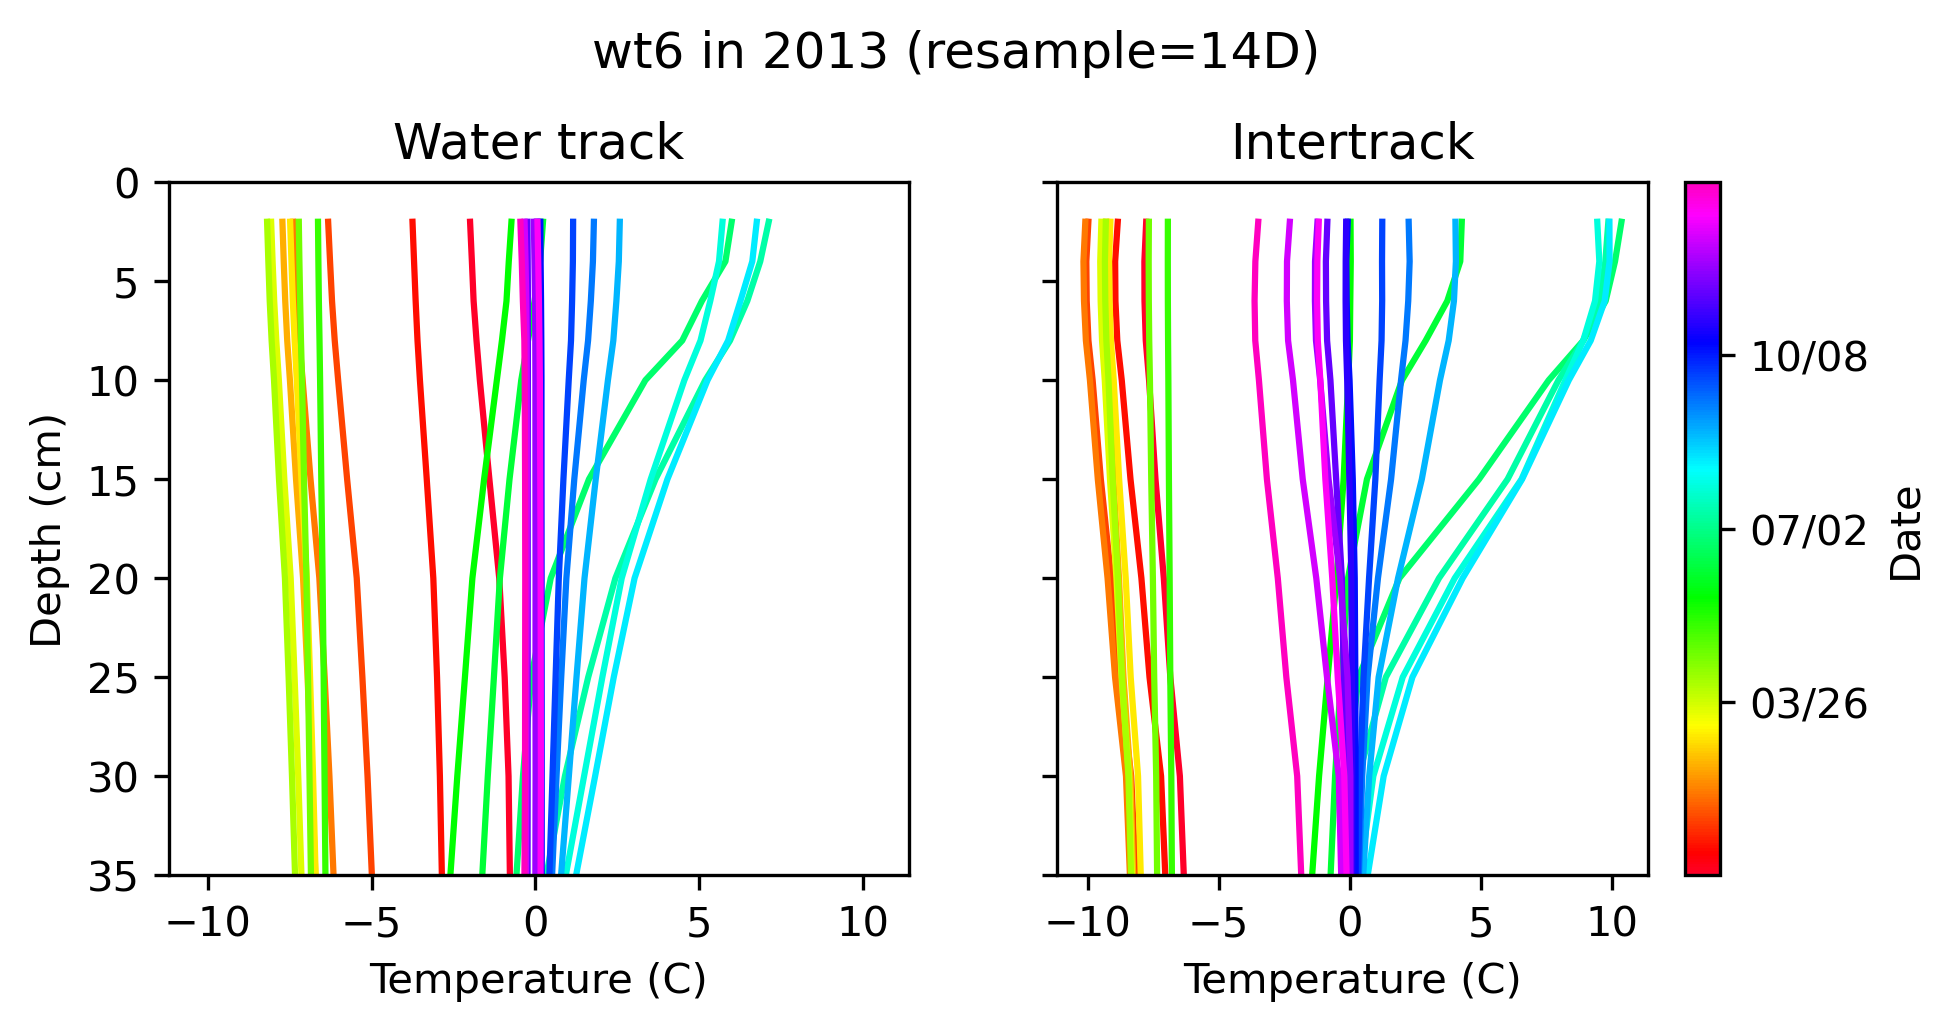

In [6]:
wt_number='wt6'
year=2013
resample = '14D'

uk_data[f'{wt_number}'] = {}

uk_data[f'{wt_number}']['resampled_in'], uk_data[f'{wt_number}']['resampled_out'], plt = resample_and_plot_1D(wt_number, resample, year=year, plot=True)

plt.savefig(f'{wt_number}_{year}_{resample}.pdf', bbox_inches='tight')

### 2D plot

In [7]:
uk_data['time_series'][uk_data['time_series']['wt']==wt_number].reset_index()['time'].min()

Timestamp('2012-05-24 18:10:00')

In [8]:
def get_2D_temps(wt_number, start_time='default', end_time='default'):
    wt = uk_data['time_series'][uk_data['time_series']['wt']==wt_number].reset_index().drop('level_0', axis=1)
    if start_time != 'default':
        wt = wt.query(f'{start_time} < time < {end_time}').reset_index()

    data_list_in = []
    data_list_out = []
    
    for depth in uk_data['depth_list'] :
        depth_data = wt[(wt['loc']=='in') & (wt['depth']==depth)]['value']
        data_list_in.append(depth_data)
        depth_data = wt[(wt['loc']=='out') & (wt['depth']==depth)]['value']
        data_list_out.append(depth_data)

    x = np.arange(0.0, len(data_list_out[0]) + 1, 1.0)

    y = np.concatenate([np.arange(0.0,12.0,2.0), np.arange(15.0, 40.0, 5.0)])

    xx, yy = np.meshgrid(x,y)

    mesh = xx, yy

    data_stacked_in = np.array(data_list_in)
    data_stacked_out = np.array(data_list_out)

    fig, ax = plt.subplots(figsize=(10,3))
    sm = ax.pcolormesh(mesh[0], mesh[1], data_stacked_in,
                    cmap='magma',
                    #    vmin=-3.5,
                    #     vmax=3.5
                    )
    ax.set_yticks(y[::2])
    ax.set_ylim(35,0)

    # Set number of ticks here
    ticks = np.linspace(0, len(data_list_out[0])-1, 10, dtype=int)
    ax.set_xticks(ticks)
    tick_labels = [wt[(wt['loc']=='in')]['time'][int(tick)].strftime('%m/%d/%y') for tick in ax.get_xticks()]
    ax.set_xticklabels(tick_labels)

    fig.suptitle(f"Temps inside {wt_number}")
    cbar = fig.colorbar(sm,
    ax=ax,
    orientation='horizontal',
    pad=0.15,
    aspect=50,
    label="Temp C"
    )

    plt.savefig(f"{wt_number}_{start_time}_{end_time}.pdf")
    plt.savefig(f"{wt_number}_{start_time}_{end_time}.png")

    return data_stacked_in, data_stacked_out, mesh, ticks, tick_labels

Compare to Seward

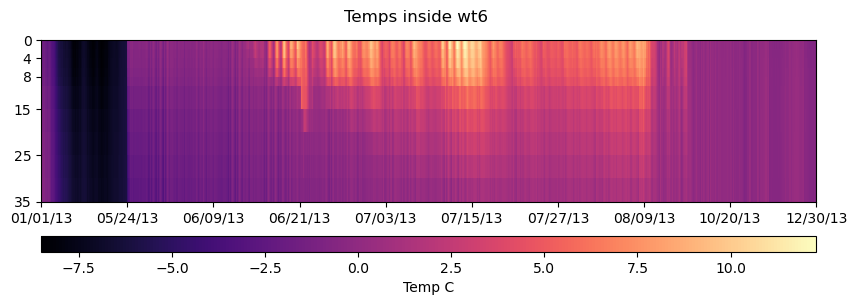

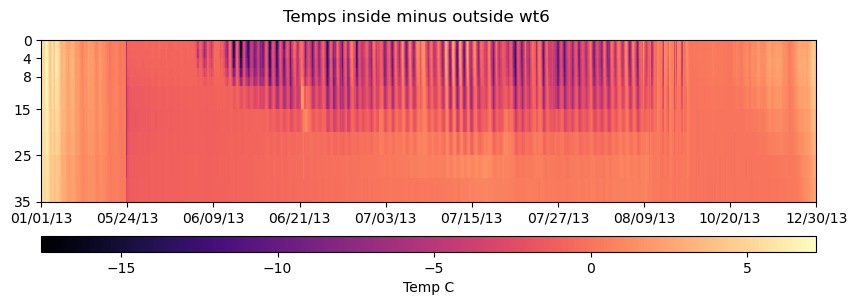

In [9]:
data_stacked_in, data_stacked_out, mesh, ticks, tick_labels= get_2D_temps('wt6', 
                                                                          start_time='20130101', end_time='20131231'
                                                                          )

wt_number = 'wt6'
fig, ax = plt.subplots(figsize=(10,3))
sm = ax.pcolormesh(mesh[0], mesh[1], data_stacked_in - data_stacked_out,
                cmap='magma',
                #    vmin=-3.5,
                #     vmax=3.5
                )
ax.set_yticks(np.concatenate([np.arange(0.0,12.0,2.0), np.arange(15.0, 40.0, 5.0)])[::2])
ax.set_ylim(35,0)

# Set number of ticks here
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

fig.suptitle(f"Temps inside minus outside {wt_number}")
cbar = fig.colorbar(sm,
ax=ax,
orientation='horizontal',
pad=0.15,
aspect=50,
label="Temp C"
)

plt.savefig(f"{wt_number}_temps_annual.pdf", bbox_inches='tight')
plt.savefig(f"{wt_number}_temps_annual.png", bbox_inches='tight')

Compare to Taylor Valley

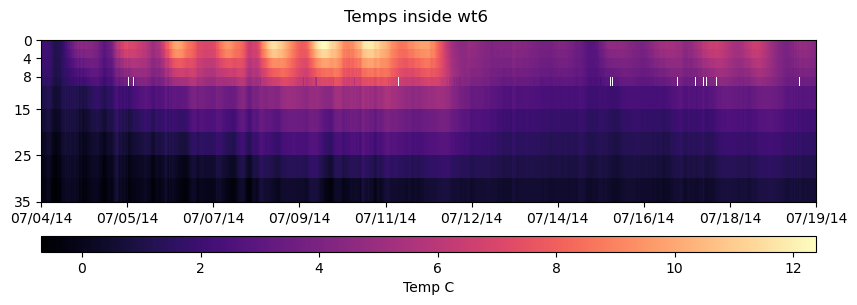

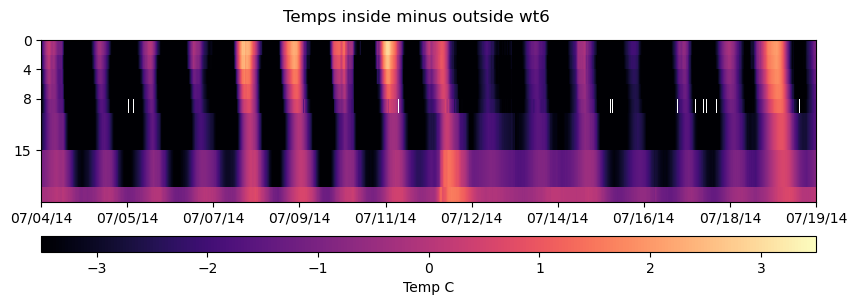

In [10]:
data_stacked_in, data_stacked_out, mesh, ticks, tick_labels= get_2D_temps('wt6', 
                                                                          start_time='20140704', end_time='20140720'
                                                                          )

wt_number = 'wt6'
fig, ax = plt.subplots(figsize=(10,3))
sm = ax.pcolormesh(mesh[0], mesh[1], data_stacked_in - data_stacked_out,
                cmap='magma',
                   vmin=-3.5,
                    vmax=3.5
                )
ax.set_yticks(np.concatenate([np.arange(0.0,12.0,2.0), np.arange(15.0, 40.0, 5.0)])[::2])
ax.set_ylim(22,0)

# Set number of ticks here
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

fig.suptitle(f"Temps inside minus outside {wt_number}")
cbar = fig.colorbar(sm,
ax=ax,
orientation='horizontal',
pad=0.15,
aspect=50,
label="Temp C"
)
plt.savefig(f"{wt_number}_temps_summer_diff.pdf", bbox_inches='tight')

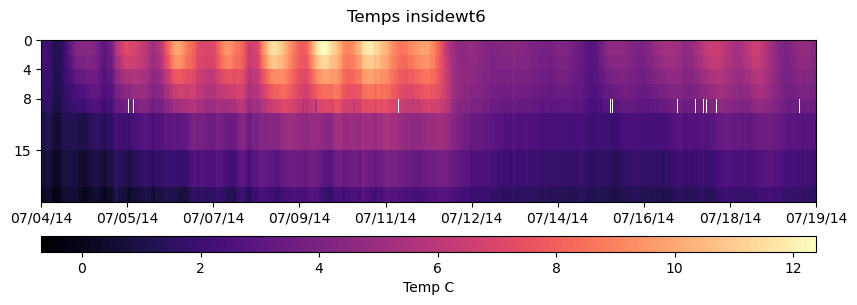

In [11]:
fig, ax = plt.subplots(figsize=(10,3))
sm = ax.pcolormesh(mesh[0], mesh[1], data_stacked_in,
                cmap='magma',
                #    vmin=-3.5,
                    # vmax=3.5
                )
ax.set_yticks(np.concatenate([np.arange(0.0,12.0,2.0), np.arange(15.0, 40.0, 5.0)])[::2])
ax.set_ylim(22,0)

# Set number of ticks here
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

fig.suptitle(f"Temps inside{wt_number}")
cbar = fig.colorbar(sm,
ax=ax,
orientation='horizontal',
pad=0.15,
aspect=50,
label="Temp C"
)
plt.savefig(f"{wt_number}_temps_summer_in.pdf", bbox_inches='tight')

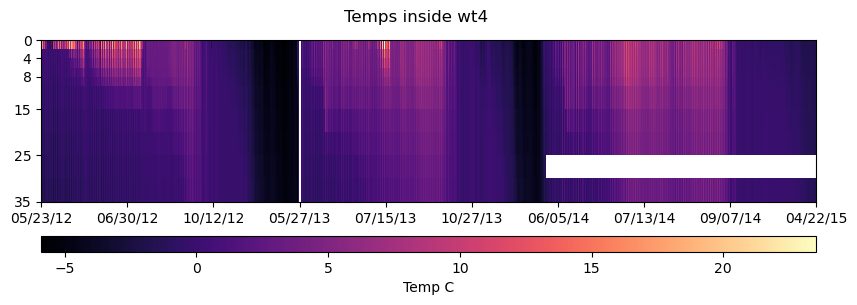

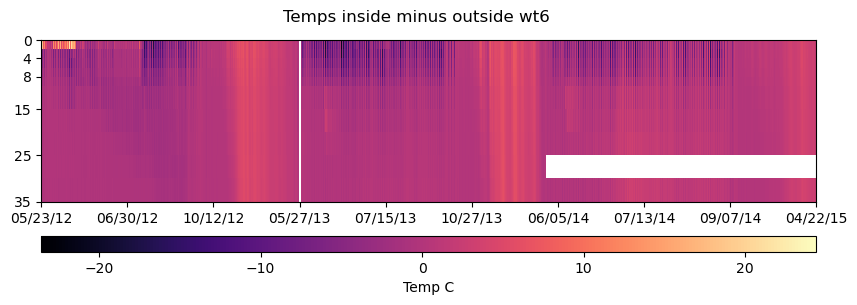

In [12]:
data_stacked_in, data_stacked_out, mesh, ticks, tick_labels= get_2D_temps('wt4',
                                                                        #    start_time='20130101', end_time='20140101'
                                                                           )
fig, ax = plt.subplots(figsize=(10,3))
sm = ax.pcolormesh(mesh[0], mesh[1], data_stacked_in - data_stacked_out,
                cmap='magma',
                #    vmin=-3.5,
                #     vmax=3.5
                )
ax.set_yticks(np.concatenate([np.arange(0.0,12.0,2.0), np.arange(15.0, 40.0, 5.0)])[::2])
ax.set_ylim(35,0)

# Set number of ticks here
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

fig.suptitle(f"Temps inside minus outside {wt_number}")
cbar = fig.colorbar(sm,
ax=ax,
orientation='horizontal',
pad=0.15,
aspect=50,
label="Temp C"
)
plt.savefig(f"{wt_number}_temps_multiyear.pdf", bbox_inches='tight')

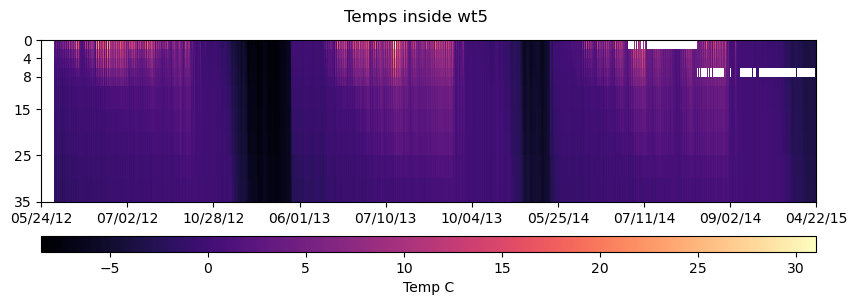

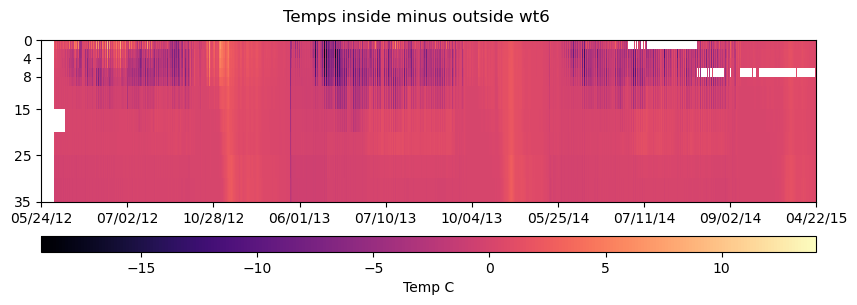

In [13]:
data_stacked_in, data_stacked_out, mesh, ticks, tick_labels= get_2D_temps('wt5',
                                                                        #    start_time='20130101', end_time='20140101'
                                                                           )
fig, ax = plt.subplots(figsize=(10,3))
sm = ax.pcolormesh(mesh[0], mesh[1], data_stacked_in - data_stacked_out,
                cmap='magma',
                #    vmin=-3.5,
                #     vmax=3.5
                )
ax.set_yticks(np.concatenate([np.arange(0.0,12.0,2.0), np.arange(15.0, 40.0, 5.0)])[::2])
ax.set_ylim(35,0)

# Set number of ticks here
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

fig.suptitle(f"Temps inside minus outside {wt_number}")
cbar = fig.colorbar(sm,
ax=ax,
orientation='horizontal',
pad=0.15,
aspect=50,
label="Temp C"
)

plt.savefig(f"{wt_number}_temps_spring.pdf", bbox_inches='tight')

### Springtime frozen layer gradients

In [14]:
wt_number='wt5'
year=2014
resample = '6H'

uk_data[f'{wt_number}'] = {}

uk_data[f'{wt_number}']['resampled_in'], uk_data[f'{wt_number}']['resampled_out'], plt = resample_and_plot_1D(wt_number, resample, year=None, plot=False)
resampled_in = uk_data[f'{wt_number}']['resampled_in']

for i, (time, group) in enumerate(resampled_in.groupby('time')):
    # print(group['value'].diff()/group['depth'].diff())
    grad = group['value'].diff()/group['depth'].diff()
    switch_points = (group['value']> 0) & (group['value'].shift(-1) < 0)
    resampled_in.loc[group.index, 'grad'] = grad
    resampled_in.loc[group.index, '0C'] = switch_points


resampled_in[resampled_in['0C']==True]

,time,index,value,depth,grad,0C
534,2012-10-05 06:00:00,NaN,0.071000,2.0,NaN,True
1489,2013-06-01 00:00:00,NaN,0.018556,2.0,NaN,True
1497,2013-06-03 00:00:00,NaN,0.042708,2.0,NaN,True
1499,2013-06-03 12:00:00,NaN,0.017667,2.0,NaN,True
1500,2013-06-03 18:00:00,NaN,0.052556,2.0,NaN,True
...,...,...,...,...,...,...
37628,2014-11-13 18:00:00,NaN,0.008000,30.0,-0.002650,True
37697,2014-12-01 00:00:00,NaN,0.029917,30.0,-0.002633,True
37699,2014-12-01 12:00:00,NaN,0.026333,30.0,-0.002183,True
37831,2015-01-03 12:00:00,NaN,0.005750,30.0,0.012683,True


In [15]:
resampled_in[resampled_in['0C']==True].groupby('depth').mean()

,time,index,value,grad,0C
depth,,,,,
2.0,2013-09-14 05:30:00.000000000,NaN,0.051602,NaN,1.0
4.0,2013-10-24 09:36:00.000000000,NaN,0.030021,-0.105503,1.0
6.0,2013-03-28 06:22:30.000000000,NaN,0.245382,-0.252439,1.0
8.0,2013-04-02 17:02:24.000000000,NaN,0.146467,-0.251127,1.0
10.0,2013-04-16 07:00:00.000000000,NaN,0.506223,-0.366570,1.0
15.0,2013-04-16 04:06:51.428571392,NaN,0.242903,-0.255511,1.0
20.0,2013-02-07 19:41:15.000000000,NaN,0.191338,-0.114229,1.0
25.0,2013-05-19 21:30:57.324840704,NaN,0.284511,-0.084090,1.0
30.0,2013-05-22 06:35:48.066298368,NaN,0.189297,-0.128383,1.0


In [16]:
resampled_in[resampled_in['0C']==True].groupby('depth').std()

,time,index,value,grad,0C
depth,,,,,
2.0,206 days 18:57:08.218909338,NaN,0.031889,NaN,0.0
4.0,304 days 09:53:13.383114756,NaN,0.051687,0.117746,0.0
6.0,334 days 11:22:52.615961480,NaN,0.277509,0.226287,0.0
8.0,362 days 02:43:00.799416224,NaN,0.098591,0.198309,0.0
10.0,321 days 20:42:54.741000508,NaN,0.552899,0.279426,0.0
15.0,312 days 06:19:56.517086768,NaN,0.255650,0.211375,0.0
20.0,280 days 15:08:34.247858024,NaN,0.170809,0.067294,0.0
25.0,310 days 11:20:31.338528796,NaN,0.279149,0.052800,0.0
30.0,302 days 21:36:28.098859592,NaN,0.165884,0.083639,0.0


In [17]:
resampled_in[resampled_in['0C']==True].groupby('depth').min()

,time,index,value,grad,0C
depth,,,,,
2.0,2012-10-05 06:00:00,NaN,0.017667,NaN,True
4.0,2012-09-11 12:00:00,NaN,0.001083,-0.354792,True
6.0,2012-05-31 06:00:00,NaN,0.012250,-0.756618,True
8.0,2012-05-30 12:00:00,NaN,0.006917,-0.728764,True
10.0,2012-05-31 00:00:00,NaN,0.002236,-1.303653,True
15.0,2012-06-07 00:00:00,NaN,0.001028,-0.755531,True
20.0,2012-06-16 00:00:00,NaN,0.000417,-0.321675,True
25.0,2012-06-21 00:00:00,NaN,0.002167,-0.209331,True
30.0,2012-07-05 00:00:00,NaN,0.000417,-0.307956,True


## Seward Peninsula

In [18]:

seward_data={
    'wt1_in':
    {
        'code' : 'FA5AC0'
    },
    'wt1_out' :
    {
        'code' : 'F74E04'
    }

}



In [19]:
for key, value in seward_data.items():
    code = value['code']
    seward_data[key]['file'] = glob.glob(f'seward_data\Data_files\Data_files\{code}*')
    df = pd.read_csv(seward_data[key]['file'][0]).drop_duplicates(subset='timestamp')
    df.replace(127.9921875, np.nan, inplace=True)
    df['time'] = pd.to_datetime(df['timestamp'])
    df.drop_duplicates(subset='time')
    seward_data[key]['timeseries'] = df

In [20]:
# I don't remember why this isn't like a join?

seward_data[list(seward_data.keys())[0]]['timeseries'] = (seward_data[list(seward_data.keys())[0]]['timeseries']
                                                           [seward_data[list(seward_data.keys())[0]]['timeseries'] ["time"].isin(
                                                               seward_data[list(seward_data.keys())[1]]['timeseries'] ["time"]
                                                               )].reset_index())
seward_data[list(seward_data.keys())[1]]['timeseries'] = (seward_data[list(seward_data.keys())[1]]['timeseries']
                                                           [seward_data[list(seward_data.keys())[1]]['timeseries'] ["time"].isin(
                                                               seward_data[list(seward_data.keys())[0]]['timeseries'] ["time"]
                                                               )].reset_index())

print(len(seward_data[list(seward_data.keys())[0]]['timeseries'] ), len(seward_data[list(seward_data.keys())[1]]['timeseries'] ))

34583 34583


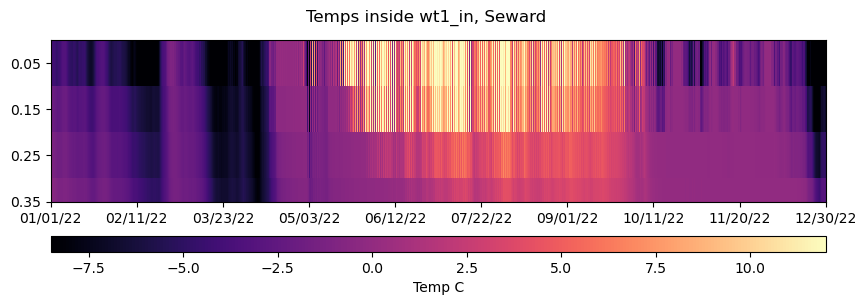

In [21]:
start_time = '20220101'
end_time  = '20221231'
wt_in = seward_data[list(seward_data.keys())[0]]['timeseries']
wt_in = wt_in.query(f'{start_time} < time < {end_time}').reset_index()

wt_out = seward_data[list(seward_data.keys())[1]]['timeseries']
wt_out = wt_out.query(f'{start_time} < time < {end_time}').reset_index()

temp_columns = [col for col in wt_in.columns if 'T' in col]

if len(temp_columns) == 13:
    depth_list = list(np.linspace(.05, 1.25, 13)) # maybe? might be 0 and 1.55 cm too. 
else:
    depth_list = list(np.linspace(.05, 1.65, 17)) # maybe? might be 0 and 1.55 cm too. 

data_list_in = []
data_list_out = []
for depth in temp_columns:
    data_list_in.append(wt_in[depth].values)
    data_list_out.append(wt_out[depth].values)
    

x = np.arange(0.0, len(data_list_in[0]), 1.0)


y = np.array(depth_list)

xx, yy = np.meshgrid(x,y)

mesh = xx, yy

data_stacked_in = np.array(data_list_in)
data_stacked_out = np.array(data_list_out)

fig, ax = plt.subplots(figsize=(10,3))
sm = ax.pcolormesh(mesh[0], mesh[1], data_stacked_in,
                cmap='magma',
                   vmin=-8.5,
                    vmax=12
                )
# ax.set_yticks(y[::2])
# ax.set_ylim(1.65, 0.0)

ax.set_yticks(y)
ax.set_ylim(0.35, 0.0)


# Set number of ticks here
ticks = np.linspace(0, len(data_list_in[0])-1, 10, dtype=int)
ax.set_xticks(ticks)
tick_labels = [wt_in['time'][int(tick)].strftime('%m/%d/%y') for tick in ax.get_xticks()]
ax.set_xticklabels(tick_labels)

fig.suptitle(f"Temps inside {list(seward_data.keys())[0]}, Seward")
cbar = fig.colorbar(sm,
ax=ax,
orientation='horizontal',
pad=0.15,
aspect=50,
label="Temp C"
)

plt.savefig(f"{list(seward_data.keys())[0]}_temps.pdf", bbox_inches='tight')
plt.savefig(f"{list(seward_data.keys())[0]}_temps.png", bbox_inches='tight')

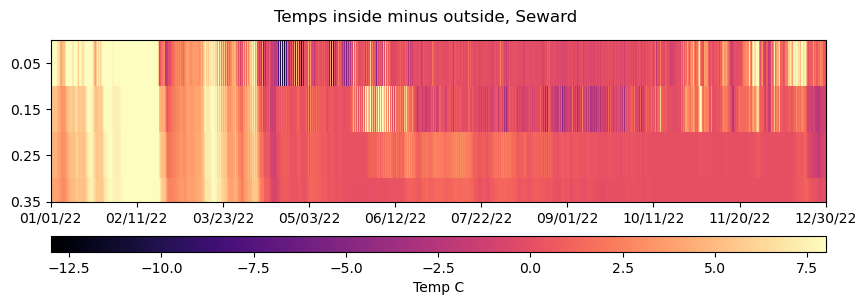

In [22]:
fig, ax = plt.subplots(figsize=(10,3))
sm = ax.pcolormesh(mesh[0], mesh[1], data_stacked_in-data_list_out,
                cmap='magma',
                   vmin=-13,
                    vmax=8
                )
# ax.set_yticks(y[::2])
# ax.set_ylim(1.65, 0.0)

ax.set_yticks(y)
ax.set_ylim(0.35, 0.0)


# Set number of ticks here
ticks = np.linspace(0, len(data_list_in[0])-1, 10, dtype=int)
ax.set_xticks(ticks)
tick_labels = [wt_in['time'][int(tick)].strftime('%m/%d/%y') for tick in ax.get_xticks()]
ax.set_xticklabels(tick_labels)

fig.suptitle(f"Temps inside minus outside, Seward")
cbar = fig.colorbar(sm,
ax=ax,
orientation='horizontal',
pad=0.15,
aspect=50,
label="Temp C"
)
plt.savefig(f"{list(seward_data.keys())[0]}_temps_diff.pdf", bbox_inches='tight')
plt.savefig(f"{list(seward_data.keys())[0]}_temps_diff.png", bbox_inches='tight')

### Springtime frozen layer gradients

In [23]:
temps = seward_data[list(seward_data.keys())[0]]['timeseries'][temp_columns]
temps['time'] = seward_data[list(seward_data.keys())[0]]['timeseries']['time']
temps = temps.resample('6H', on='time').mean()
# temps

C:\Users\jdelvecchio01\AppData\Local\Temp\ipykernel_33484\1691456516.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temps['time'] = seward_data[list(seward_data.keys())[0]]['timeseries']['time']


In [24]:
temp_diffs = temps[temp_columns].diff(axis=1)
temp_diffs = temp_diffs / 5 #every 5 cm
temp_diffs['time'] = temps.index
# temp_diffs


In [25]:
thawed = temps[temp_columns] > 0 
frozen_below = temps[temp_columns].shift(-1, axis=1) < 0

In [26]:
temp_diffs[(thawed & frozen_below)].mean()

T1           NaN
T2     -0.963127
T3     -1.214185
T4     -0.378182
T5     -0.176706
T6      -0.03715
T7     -0.179348
T8     -0.180182
T9     -0.073262
T10    -0.070732
T11    -0.047321
T12          NaN
T13          NaN
T14          NaN
T15          NaN
T16          NaN
T17          NaN
time         NaT
dtype: object

In [27]:
temp_diffs[(thawed & frozen_below)].min()

T1           NaN
T2      -3.08138
T3     -2.903516
T4     -0.610807
T5     -0.244401
T6     -0.268359
T7     -0.254427
T8      -0.21862
T9     -0.197135
T10     -0.11875
T11    -0.111068
T12          NaN
T13          NaN
T14          NaN
T15          NaN
T16          NaN
T17          NaN
time         NaT
dtype: object

## Taylor Valley

In [28]:
df = pd.read_csv('antarctica_data\Linhardt-etal_2019\datasets\Taylor_valley_WT.tab', sep='\t', skiprows=199)
df['time'] = pd.to_datetime(df['Date/Time (Center time of averaging inte...)'])

temp_columns = [col for col in df.columns if 'Soil temperature' in col]



In [29]:
df

,Date/time start (Start time of averaging inter...),Date/time end (End time of averaging interva...),Date/Time (Center time of averaging inte...),"DOY [day] (Doy of Year, fractional (deci...)","Height [m] (Aerodynamic height (z-d), whe...)",Elevation [m a.s.l.] (Elevation),Latitude (Latitude),Longitude (Longitude),UTC offset (UTC offset),SZA [deg] (Zenith angle of the sun),...,"T soil [°C] (Soil temperature, thermistor ...).7","Depth soil [m] (Depth in the soil, thermistor...).7",Heat storage change [W/m**2] (Heat storage change in the th...),"NET [W/m**2] (Total net radiation, correcte...)","Qh [W/m**2] (Sensible heat flux, corrected...)","Qe [W/m**2] (Latent heat flux, corrected f...)",Heat storage change [W/m**2] (Heat storage change in the th...).1,Soil heat flux [W/m**2] (Soil heat flux at ice tabe de...),"Ground heat flux [W/m**2] (Ground heat flux, calculated ...)",time
0,2012-12-26T21:00,2012-12-26T21:30,2012-12-26T21:15,361.885417,2.05,33.0,-77.57653,163.48358,12.0,73.560337,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2012-12-26 21:15:00
1,2012-12-26T21:30,2012-12-26T22:00,2012-12-26T21:45,361.906250,2.05,33.0,-77.57653,163.48358,12.0,74.803583,...,NaN,NaN,-47.500710,104.427,NaN,NaN,NaN,NaN,NaN,2012-12-26 21:45:00
2,2012-12-26T22:00,2012-12-26T22:30,2012-12-26T22:15,361.927083,2.05,33.0,-77.57653,163.48358,12.0,75.912446,...,NaN,NaN,-71.610919,67.451,52.736612,29.762984,NaN,NaN,-15.048596,2012-12-26 22:15:00
3,2012-12-26T22:30,2012-12-26T23:00,2012-12-26T22:45,361.947917,2.05,33.0,-77.57653,163.48358,12.0,76.870658,...,NaN,NaN,-60.455449,58.449,36.872247,20.301284,NaN,NaN,1.275469,2012-12-26 22:45:00
4,2012-12-26T23:00,2012-12-26T23:30,2012-12-26T23:15,361.968750,2.05,33.0,-77.57653,163.48358,12.0,77.664201,...,NaN,NaN,-35.985386,63.890,37.987838,23.524939,NaN,NaN,2.377223,2012-12-26 23:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,2013-01-21T11:00,2013-01-21T11:30,2013-01-21T11:15,21.468750,2.05,33.0,-77.57653,163.48360,12.0,59.522260,...,0.696500,0.24,13.086340,335.639,90.186990,25.576260,13.08634,206.78940,219.875700,2013-01-21 11:15:00
1229,2013-01-21T11:30,2013-01-21T12:00,2013-01-21T11:45,21.489580,2.05,33.0,-77.57653,163.48360,12.0,58.731150,...,0.641333,0.24,94.122230,440.599,143.062200,33.530450,94.12223,169.88410,264.006400,2013-01-21 11:45:00
1230,2013-01-21T12:00,2013-01-21T12:30,2013-01-21T12:15,21.510420,2.05,33.0,-77.57653,163.48360,12.0,58.147940,...,0.611750,0.24,108.435900,392.361,172.309800,42.065360,108.43590,69.54994,177.985900,2013-01-21 12:15:00
1231,2013-01-21T12:30,2013-01-21T13:00,2013-01-21T12:45,21.531250,2.05,33.0,-77.57653,163.48360,12.0,57.786630,...,NaN,NaN,628.687600,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-21 12:45:00


In [30]:
depth_list = [0.01, 0.04, 0.12, 0.22]

data_in = ['T soil [°C] (Soil temperature, thermistor ...)',
           'T soil [°C] (Soil temperature, thermistor ...).1',
           'T soil [°C] (Soil temperature, thermistor ...).2',
           'T soil [°C] (Soil temperature, thermistor ...).3',
           ]

data_out = ['T soil [°C] (Soil temperature, thermistor ...).4',
           'T soil [°C] (Soil temperature, thermistor ...).5',
           'T soil [°C] (Soil temperature, thermistor ...).6',
           'T soil [°C] (Soil temperature, thermistor ...).7',
           ]

In [59]:
df[data_in]

,"T soil [°C] (Soil temperature, thermistor ...)","T soil [°C] (Soil temperature, thermistor ...).1","T soil [°C] (Soil temperature, thermistor ...).2","T soil [°C] (Soil temperature, thermistor ...).3"
0,10.761000,7.970000,6.763000,3.564000
1,11.093833,8.053333,6.737333,3.472167
2,11.609000,8.373500,6.986000,3.625833
3,11.916333,8.671833,7.250833,3.757333
4,12.154667,8.936333,7.502167,3.892833
...,...,...,...,...
809,-0.088000,0.388667,0.577000,1.003167
810,-0.088000,0.356000,0.526667,0.962000
811,0.345500,0.397833,0.526667,0.966500
812,2.664833,0.851667,0.641167,0.971000


In [31]:
df.loc[df[data_in[0]].notna()][temp_columns]

,"T soil [°C] (Soil temperature, thermocouple 1)","T soil [°C] (Soil temperature, thermocouple 2)","T soil [°C] (Soil temperature, thermistor ...)","T soil [°C] (Soil temperature, thermistor ...).1","T soil [°C] (Soil temperature, thermistor ...).2","T soil [°C] (Soil temperature, thermistor ...).3","T soil [°C] (Soil temperature, thermistor ...).4","T soil [°C] (Soil temperature, thermistor ...).5","T soil [°C] (Soil temperature, thermistor ...).6","T soil [°C] (Soil temperature, thermistor ...).7"
417,11.298,12.117,10.761000,7.970000,6.763000,3.564000,9.805000,11.224000,7.569000,11.443000
418,11.619,12.324,11.093833,8.053333,6.737333,3.472167,9.646500,11.461000,8.262833,7.774167
419,11.986,12.686,11.609000,8.373500,6.986000,3.625833,13.030833,10.393833,7.309667,3.243333
420,10.673,12.239,11.916333,8.671833,7.250833,3.757333,13.778000,10.438667,7.363833,3.080500
421,12.607,12.546,12.154667,8.936333,7.502167,3.892833,14.138000,10.581500,7.431333,3.036000
...,...,...,...,...,...,...,...,...,...,...
1226,0.342,NaN,-0.088000,0.388667,0.577000,1.003167,0.727833,-0.180500,-0.074000,0.811000
1227,2.416,NaN,-0.088000,0.356000,0.526667,0.962000,2.911000,0.259167,-0.046000,0.756167
1228,9.455,NaN,0.345500,0.397833,0.526667,0.966500,7.851333,1.477500,0.023667,0.696500
1229,10.770,NaN,2.664833,0.851667,0.641167,0.971000,11.624170,3.863500,0.310167,0.641333


In [32]:
df = df[df[data_in[0]].notna()].reset_index()

In [33]:
depth_columns = [col for col in df.columns if 'Depth soil' in col]
df[depth_columns].mean()


Depth soil [m] (Depth in the soil, thermocoup...)      0.004
Depth soil [m] (Depth in the soil, thermocoup...).1    0.004
Depth soil [m] (Depth in the soil, thermistor...)      0.010
Depth soil [m] (Depth in the soil, thermistor...).1    0.040
Depth soil [m] (Depth in the soil, thermistor...).2    0.120
Depth soil [m] (Depth in the soil, thermistor...).3    0.220
Depth soil [m] (Depth in the soil, thermistor...).4    0.010
Depth soil [m] (Depth in the soil, thermistor...).5    0.040
Depth soil [m] (Depth in the soil, thermistor...).6    0.120
Depth soil [m] (Depth in the soil, thermistor...).7    0.240
dtype: float64

In [34]:


data_list_in = []
for depth in data_in:
    data_list_in.append(df[depth].values)

data_list_out = []
for depth in data_out:
    data_list_out.append(df[depth].values)

x = np.arange(0.0, len(data_list_out[0]), 1.0)


y = np.array(depth_list)

xx, yy = np.meshgrid(x,y)

data_stacked_in = np.array(data_list_in)
data_stacked_out = np.array(data_list_out)

In [61]:
depth

'T soil [°C] (Soil temperature, thermistor ...).7'

In [35]:
len(data_list_in[0])

814

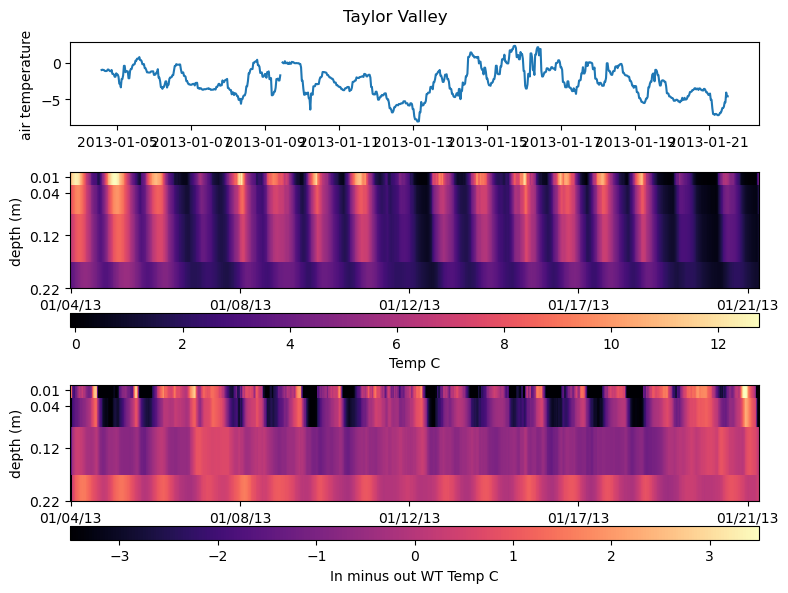

In [36]:
fig, ax = plt.subplots(3,1, figsize=(8,6), gridspec_kw={'height_ratios': [1, 2, 2]})

ax[0].plot(df['time'], df['TTT [°C] (Reference temperature)'])
ax[0].set_ylabel("air temperature")


sm = ax[1].pcolormesh(xx,yy, data_stacked_in,
                   cmap='magma',
                #    vmin=-3.5,
                    # vmax=3.5
                   )
ax[1].set_yticks(y)
ax[1].set_ylim(.22, 0.0)
ax[1].set_xticks(np.arange(0., len(data_list_in[0]), 200))
cbar = fig.colorbar(sm,
  ax=ax[1],
   orientation='horizontal',
   pad=0.15,
   aspect=50,
   label="Temp C"
   )

ax[1].set_xticklabels(df['time'][int(tick)].strftime('%m/%d/%y') for tick in ax[1].get_xticks())
ax[1].set_ylabel("depth (m)")


sm = ax[2].pcolormesh(xx,yy, data_stacked_in-data_stacked_out,
                   cmap='magma',
                   vmin=-3.5,
                    vmax=3.5
                   )
ax[2].set_yticks(y)
ax[2].set_ylim(.22, 0.0)
ax[2].set_xticks(np.arange(0., len(data_list_in[0]), 200))
cbar = fig.colorbar(sm,
  ax=ax[2],
   orientation='horizontal',
   pad=0.15,
   aspect=50,
   label="In minus out WT Temp C"
   )

ax[2].set_xticklabels(df['time'][int(tick)].strftime('%m/%d/%y') for tick in ax[2].get_xticks())
ax[2].set_ylabel("depth (m)")

fig.suptitle("Taylor Valley")

fig.tight_layout()

plt.savefig(f"Taylor Valley_temps.pdf", bbox_inches='tight')